In [1]:
%run init_notebookspace.py
from settings import *

## Table of Content
* [Make RBC Model](#chapter1)
    * [Model Equations](#section_1_1)
    * [Find Steady State, Solve the Model](#section_1_2)
* [Get Italy data](#chapter2)
* [Preprocessing the data](#chapter3)
    * [Log-Transforming of the Data](#section_3_1)
    * [Detrending the Data](#section_3_2)
    * [Detrending the Data](#section_3_3)
* [Maximum Likelihood Estimation](#chapter4)
    * [MLE Kalman Filter Prediction](#section_4_1)
    * [Kalman Smoother output](#section_4_2)
    * [Impulse response](#section_4_3)

In [2]:
%matplotlib inline
# import gEcon as ge
# import gEcon.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend

# from TimeSeriesTools.stats import ADF_test_summary
# from TimeSeriesTools.transformers import DetrendTransformer, LogTransformer

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

## Make RBC Model <a class="anchor" id="chapter1"></a>

In [3]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc.gnc'))

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



### Model Equations  c

In [4]:
for equation in rbc.system_equations:
    display(equation)

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

### Find Steady State, Solve the Model <a class="anchor" id="section_1_2"></a>

In [5]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  1.0823547763477462e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [6]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436


## Get Italy data <a class="anchor" id="chapter2"></a>

We want series for consumption, investment, labor, GDP, interest rate, and wages

In [3]:
data = pd.read_csv(os.path.join(DATA_DIR, "all_rbc_data.csv"), infer_datetime_format="QS")
data["TIME"] = time_format(data.TIME)
data.set_index("TIME", drop=True, inplace=True)
data.sort_index(inplace=True)

data.rename(columns=dict(zip(data.columns, ["Y", "I", "Z", "X", "r", "C", "w", "L"])), inplace=True)

data.drop(["X", "Z"], axis=1, inplace=True)

## Prepocessing the Data <a class="anchor" id="chapter3"></a>

In [4]:
# check for na
print("NaNs \n", data.isna().sum())
df = data.copy()

NaNs 
 Y     0
I     0
r     0
C     0
w    36
L     0
dtype: int64


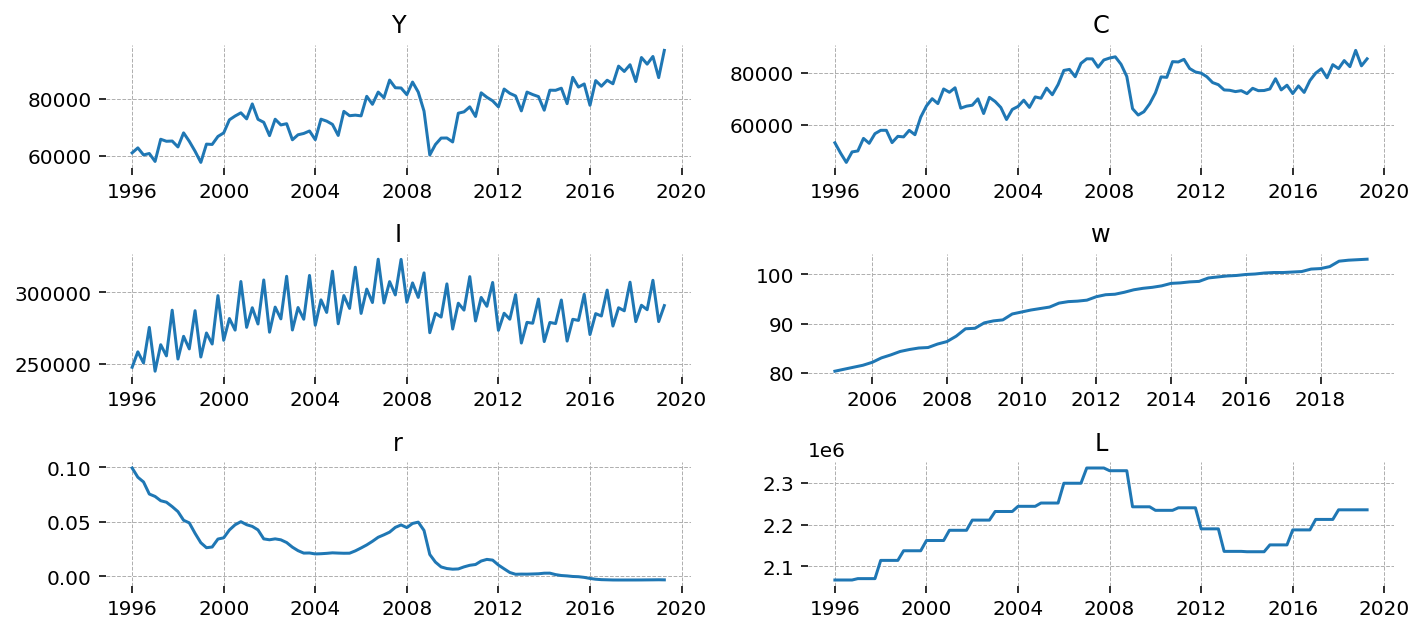

In [5]:
# raw data
plot_df(data)

### Log-transformation <a class="anchor" id="section_3_1"></a>

In [6]:
# log transform
for col in [item for item in df.columns if item != "r"]:
    df[col] = apply_func(df[col], func=np.log)

Raw data is log transformed, thus somehow equalised in scale

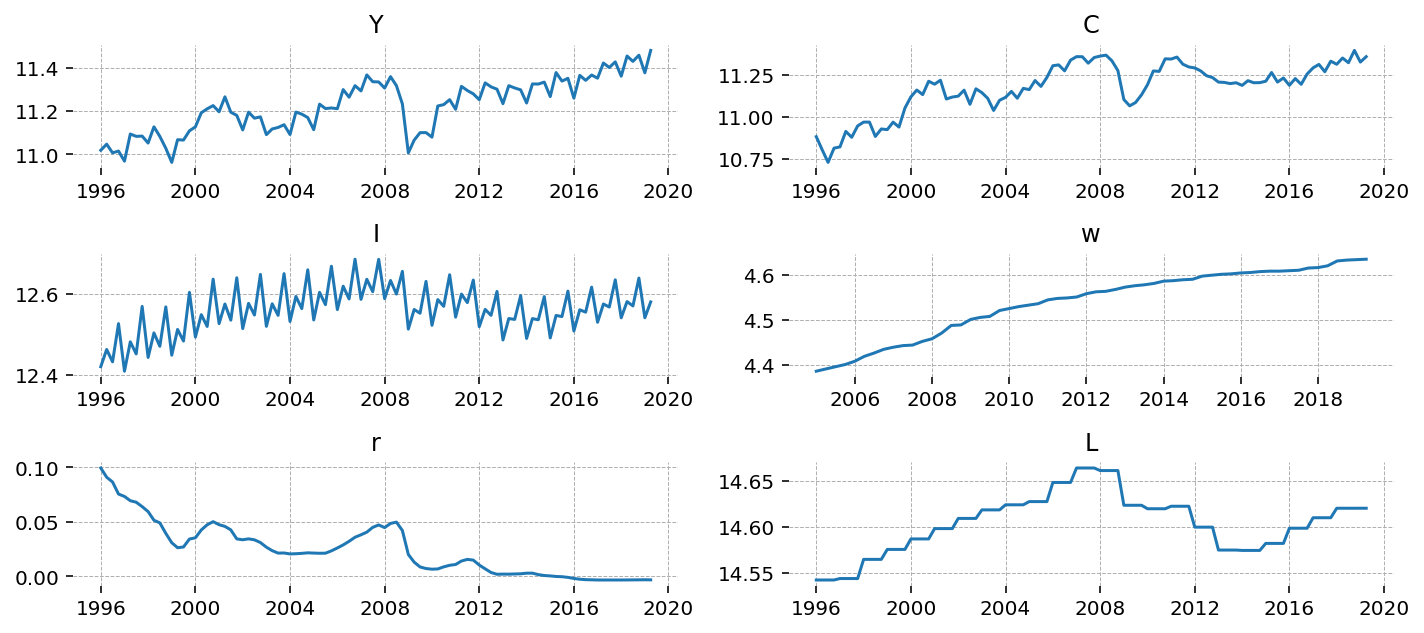

In [7]:
plot_df(df)

### Detrend the Data <a class="anchor" id="section_3_3"></a>

The HP filter identified the underlying trend. Yet the trend is by nature non-stationary, thus not suitable to most statistical procedures. For detrending we use a 2nd order polynomial detrender.

[nan nan]


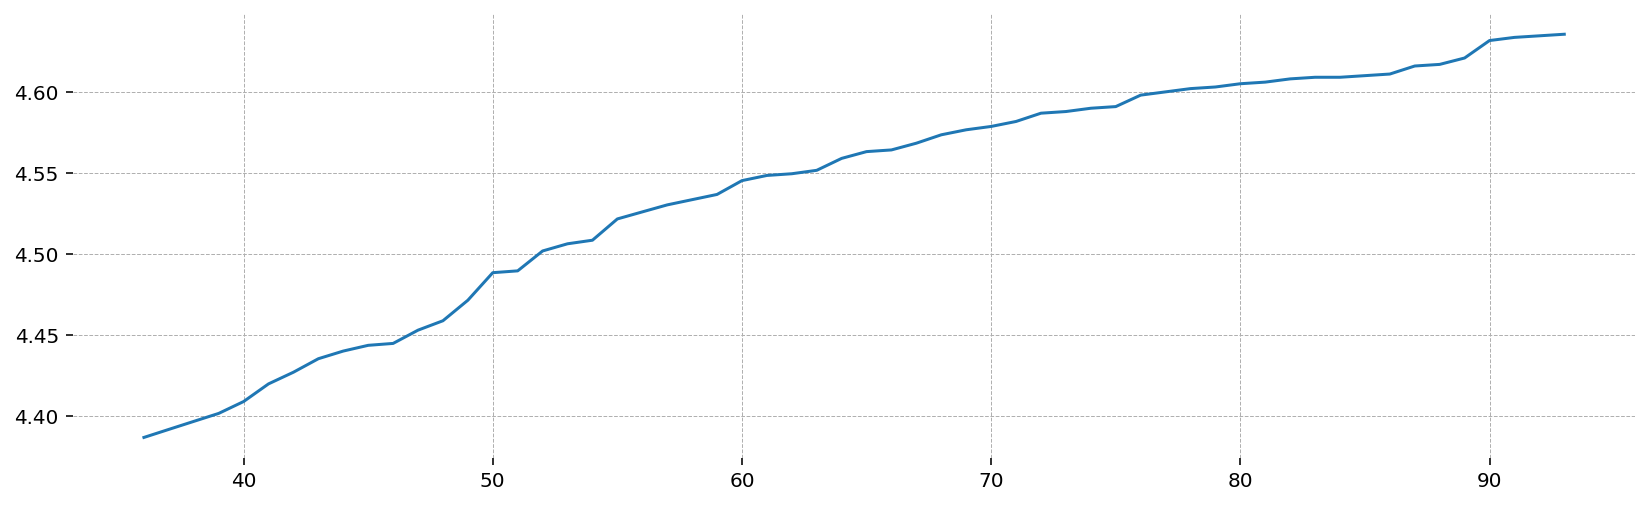

In [8]:
arr = df.w.copy()
arrx = range(0, len(arr))
model = np.polyfit(arrx, arr.values, 1)
print(model)

plt.plot(arr.values)
plt.plot(np.polyval(model, arrx))

In [10]:
mask = df.copy()
for col in df:
    df[col] = poly_detrend(df[col], poly_order=2, skipna=True)
    mask[col] = poly_detrend(df[col], poly_order=2, skipna=True, return_pred=True)

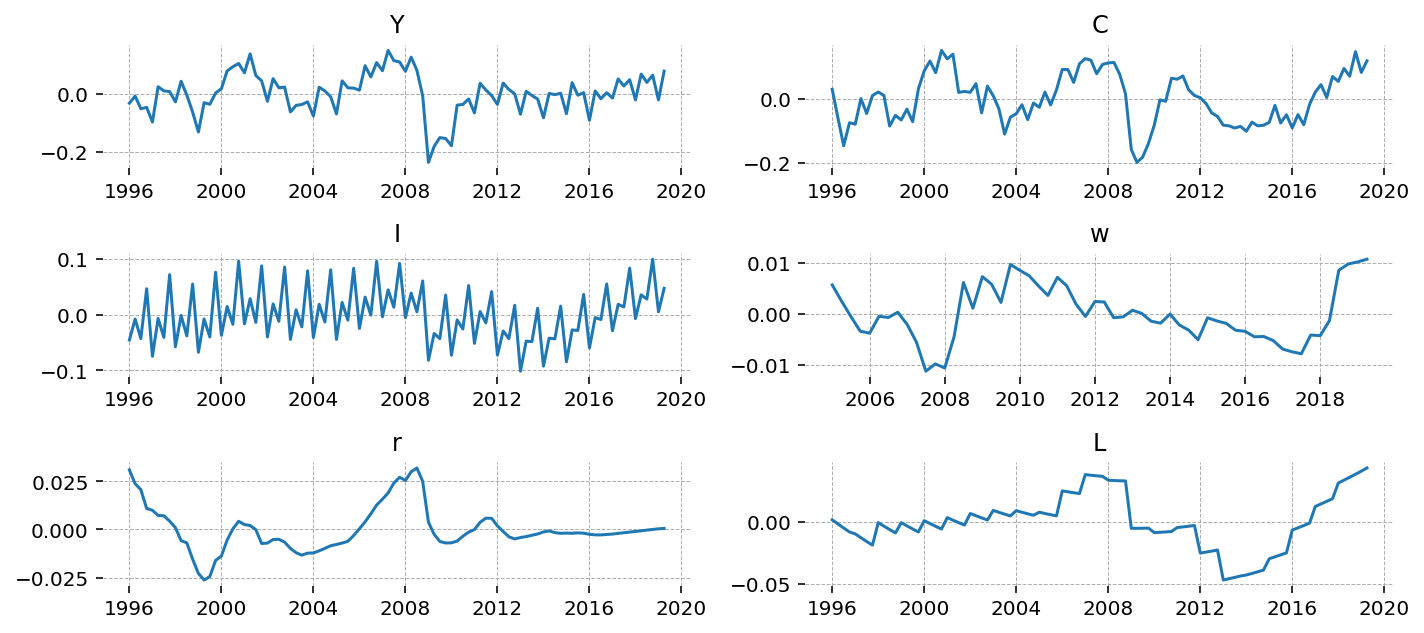

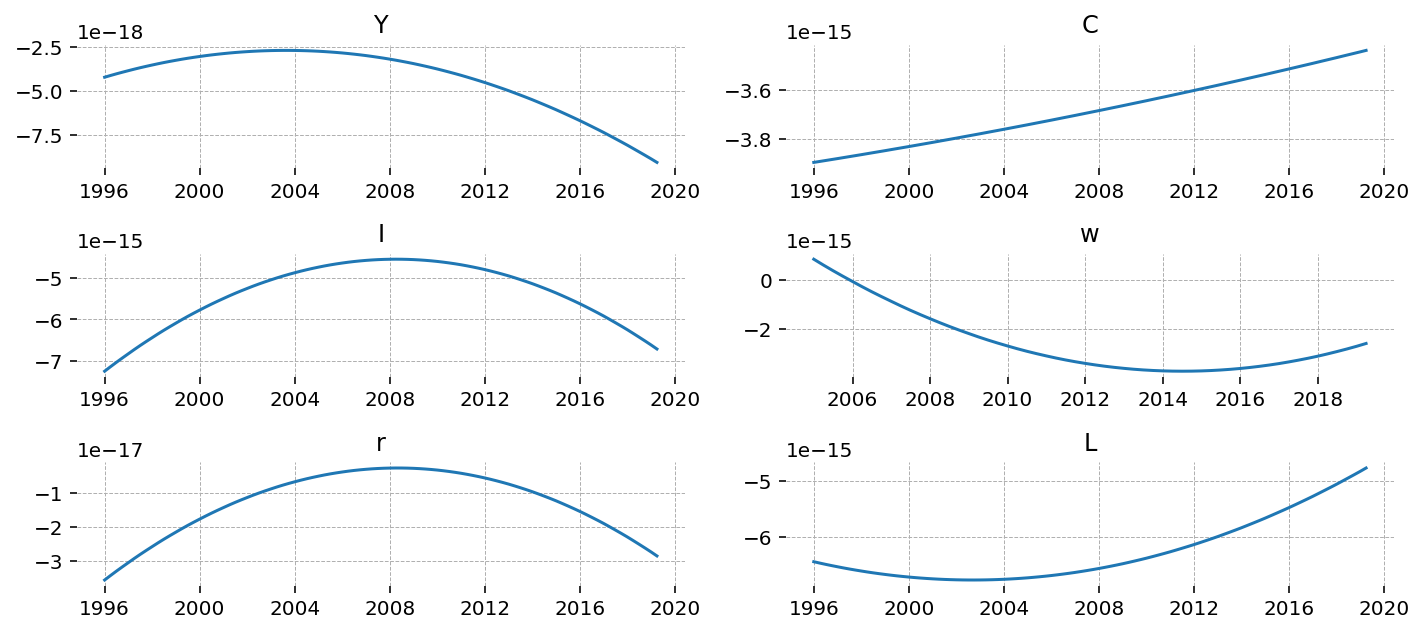

In [15]:
plot_df(df)
plot_df(mask)

### Deseasonalise the Data <a class="anchor" id="section_3_2"></a>

In [39]:
desea_cols = ['Y', 'I', 'C', 'w', 'L'] # r not seasonal
for col in desea_cols:
    df[col] = get_seasonal_hp(df[col], lamb=6.25, skipna=True, )

For deseasonalisation we chose the Hodrick-Prescott filter, which identifies the underlying trend

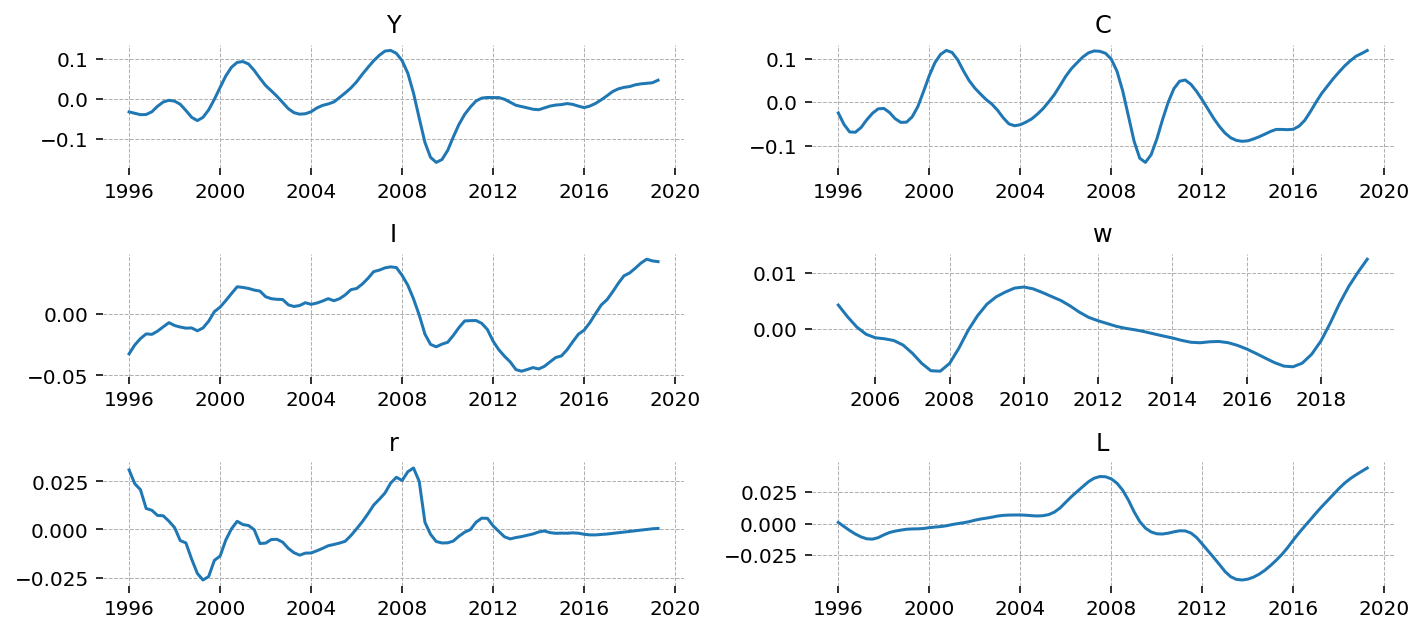

In [40]:
plot_df(df)

### Check stationarity after tranformation <a class="anchor" id="section_3_3"></a>

In [44]:
for col in df.columns:
    arr_adf(df[col], skipna=True, p_level=.1)

Y  p-val: 0.061993751504167915,  reject: True
I  p-val: 0.08810746779728951,  reject: True
r  p-val: 0.00887241125533289,  reject: True
C  p-val: 0.13465399259285532,  reject: False
w  p-val: 0.079272347620638,  reject: True
L  p-val: 0.03702931818509586,  reject: True


## Maximum Likelihood Estimation <a class="anchor" id="chapter4"></a>

In [45]:
# assign date freq
df = df.asfreq("QS")

In [46]:
df.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,-0.032228,-0.032402,0.031027,-0.024573,NaN,0.000863
1996-04-01,-0.035619,-0.025153,0.023845,-0.050817,NaN,-0.002345
1996-07-01,-0.039140,-0.019975,0.020751,-0.068148,NaN,-0.005451
1996-10-01,-0.038587,-0.016126,0.010947,-0.068910,NaN,-0.008264
1997-01-01,-0.031844,-0.016498,0.009998,-0.057862,NaN,-0.010531


In [89]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [90]:
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52, 'delta':0.01} 
rbc.free_param_dict.update(calibrated_params)

In [91]:
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

# NOTE: We have to change this parameters probably

param_start_dict = {'sigma_C':1.5, 
                    'sigma_L':2.0,
#                     'alpha':0.5,
                    'rho_A':0.85}

shock_start_dict = {
    'epsilon_A':0.5
}

noise_start_dict = {
#     'Y':0.01,
    'C':0.02,
    'L':0.05,
    'I':0.02,
    'r':0.03,
    'w':0.1
}

# The slope parameter controls the steepness of the gradient around 0 (lower slope = more gentle gradient)
param_transforms = {
    'sigma_C': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'sigma_L': IntervalTransformer(low=1.05, high=10.0, slope=1),
    'rho_A':IntervalTransformer(low=1e-4, high=0.99, slope=1),
#     'alpha':IntervalTransformer(low=0.1, high=0.80, slope=1)
}

mle_mod = MLEModel(df,
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [92]:
mle_res = mle_mod.fit(method='nm', maxiter=10_000)
mle_res = mle_mod.fit(method='lbfgs', maxiter=1_000, start_params=mle_res.params)

Optimization terminated successfully.
         Current function value: -8.774816
         Iterations: 1418
         Function evaluations: 2150


In [93]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'I', 'r', 'C', 'w', 'L']   No. Observations:                   94
Model:                                  DSGEModel   Log Likelihood                 284.542
Date:                            Fri, 02 Dec 2022   AIC                           -551.083
Time:                                    10:13:53   BIC                           -528.194
Sample:                                01-01-1996   HQIC                          -541.837
                                     - 04-01-2019                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma_C              1.0500     32.092      0.033      0.974     -61.849      63.949
sigma_L             10.0000    656.656      0.015      0.988   -1277.023    1297.023
rho_A                0.9900      0.144      6.887      0.000       0.708       1.272
sigma2.epsilon_A     0.0197      0.144      0.137      0.891      -0.263       0.302
sigma2.C             0.1961      1.873      0.105      0.917      -3.474       3.866
sigma2.L             0.0551      0.841      0.066      0.948      -1.593       1.704
sigma2.I             0.0668      0.733      0.091      0.927      -1.369       1.503
sigma2.r             0.0592      0.039      1.513      0.130      -0.017       0.136
sigma2.w             0.0199      0.299      0.067      0.947      -0.566       0.606
=============================================================================================================================
Ljung-Box (L1) (Q):     79.80, 87.57, 88.95, 85.81, 88.16, 90.51   Jarque-Bera (JB):   71.79, 23.86, 47.25, 4.20, 43.53, 0.86
Prob(Q):                      0.00, 0.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):               0.00, 0.00, 0.00, 0.12, 0.00, 0.65
Heteroskedasticity (H):       0.12, 0.12, 0.22, 2.43, inf, 17.13   Skew:                 -1.29, 0.77, 1.19, 0.12, 0.55, -0.21
Prob(H) (two-sided):          0.00, 0.00, 0.00, 0.02, 0.00, 0.00   Kurtosis:               6.42, 4.92, 5.52, 1.99, 6.15, 2.78
=============================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

## MLE Kalman Filter Prediction <a class="anchor" id="section_4_1"></a>

In [94]:
def plot_sm_results(res, filter_output='predicted'):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = mle_res.states.predicted.columns
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(mle_res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(mle_res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            mle_res.data.orig_endog[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

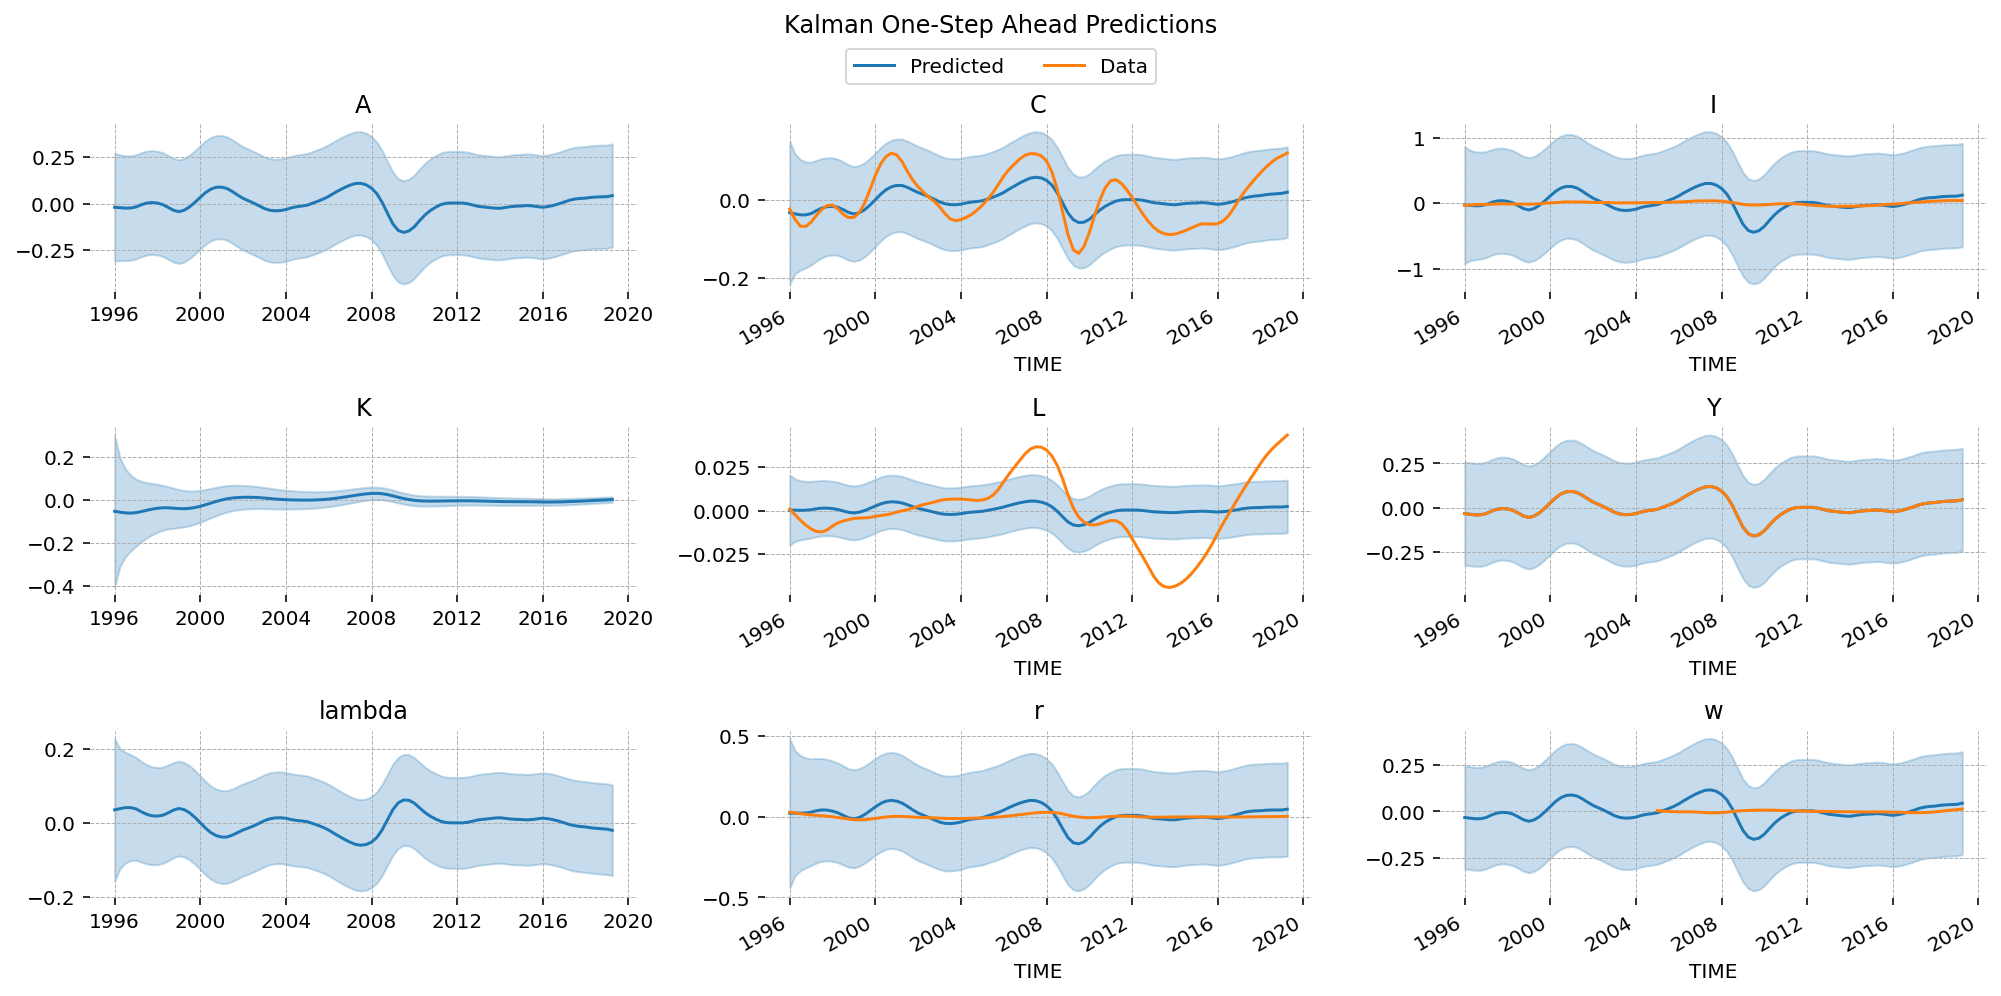

In [95]:
plot_sm_results(mle_res)

## Kalman Smoother output <a class="anchor" id="section_4_2"></a>

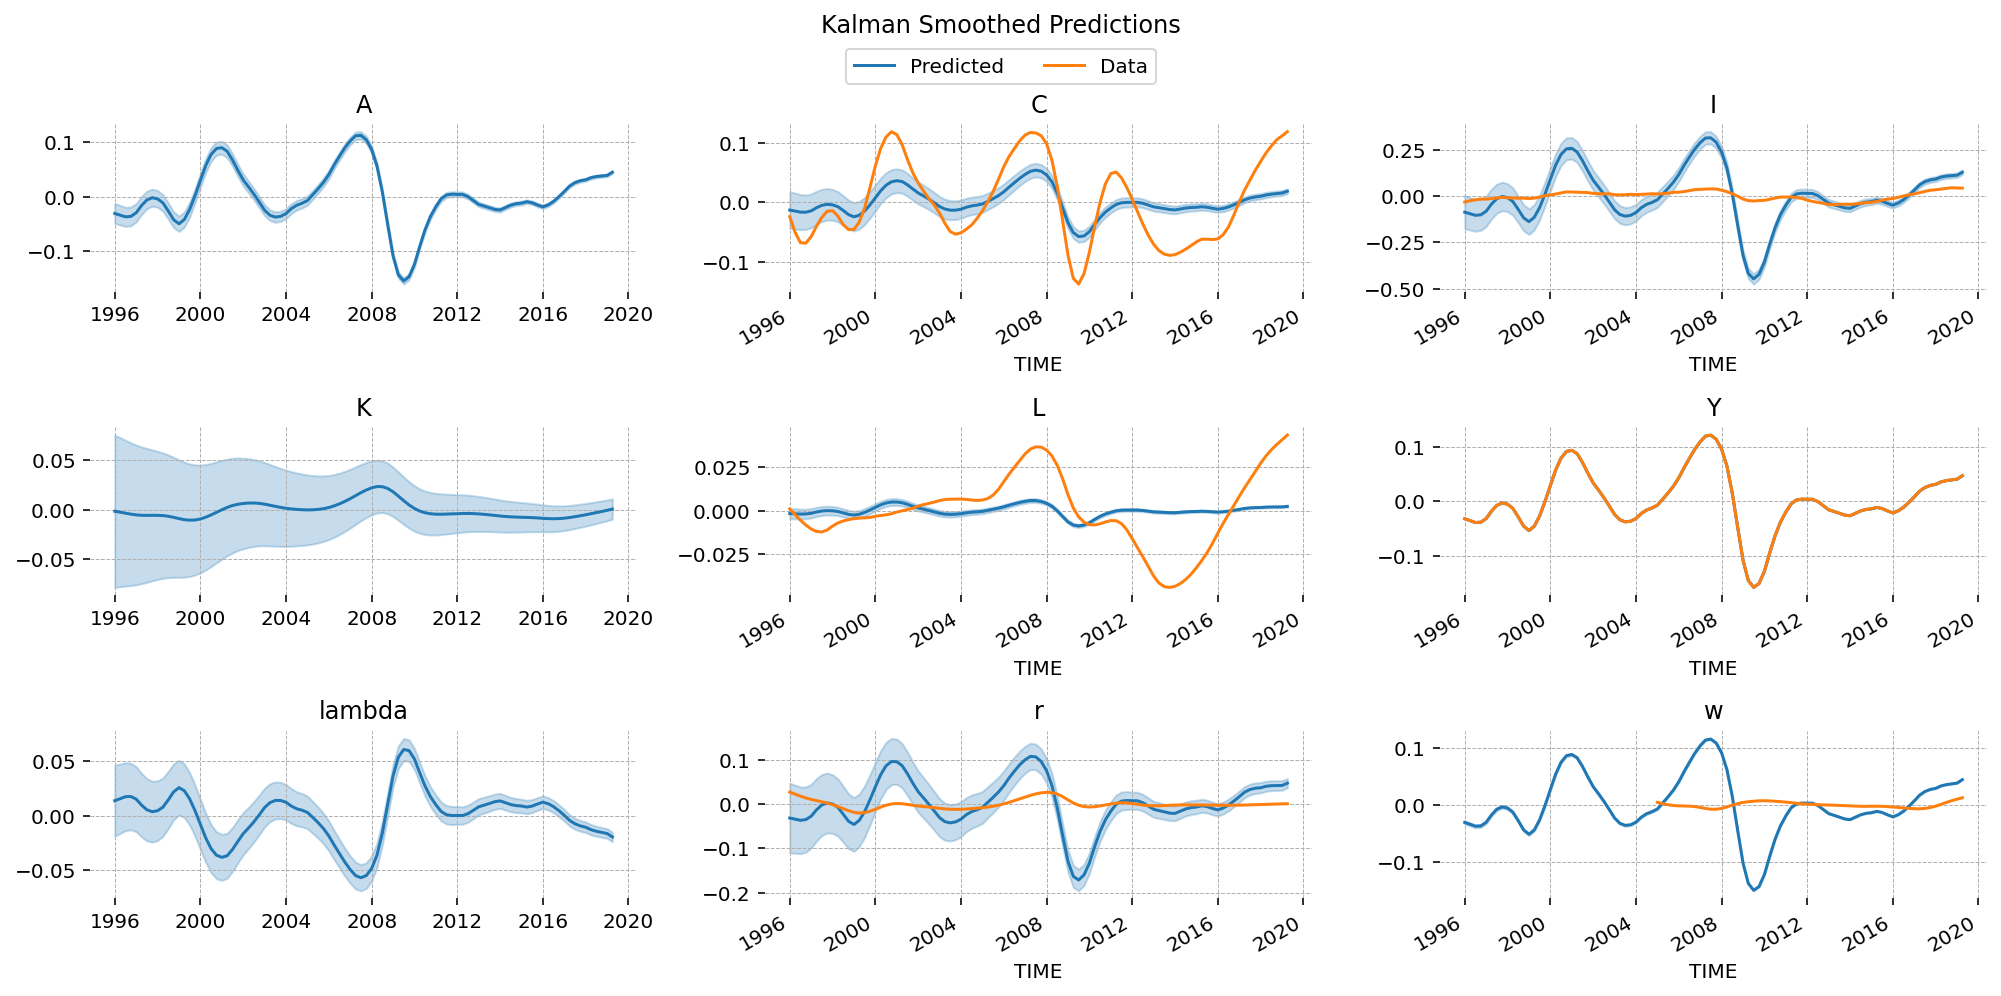

In [96]:
plot_sm_results(mle_res, 'smoothed')

## Impulse response <a class="anchor" id="section_4_3"></a>

In [97]:
irf_df = mle_res.impulse_responses(impulse=0, steps=1_000, orthogonalized=False)
irf_df.index = pd.MultiIndex.from_product([irf_df.index, ['epsilon_A']], names=['Time', 'Shocks'])
irf_df.columns.name = 'Variables'

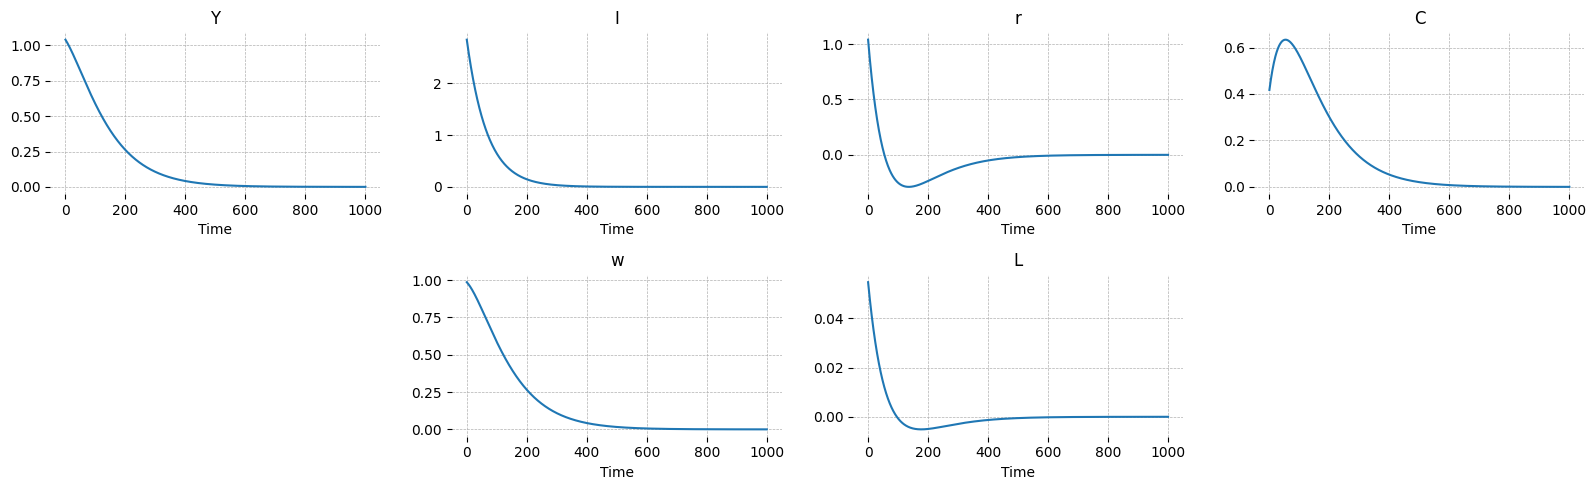

In [98]:
fig = gp.plot_irf(irf_df.T, shocks_to_plot='epsilon_A', figsize=(16,5))
plt.show()